# Integrate a nondimensional form of the equation

This notebook contains the code necessary to call the LSODA integrator on a reparametrized form of the reaction diffusion equation (see the main notebook *main_rxndiff_solver.ipynb* for details). For this notebook, time has been rescaled so that the ugly $t^{1-\alpha}$ term now appears on the reaction portion as $t^{\frac{1}{\alpha} - 1}$. A few other standard rescalings have been performed as well, such that the equation that is being solved looks like:


This integrator appears to fail at early times due to an instability that propagates from the edge of the reaction zone. This is different than the behavior of the standard, dimensional form of the reaction-diffusion equation, which appears to fail due to an instability that propagates from the origin

*If you are current reading an HTML file, then you are looking at a static snapshot of the .ipynb version of this file.*

#### Preamble (Import necessary packages)

In [1]:
# import matplotlib
# matplotlib.use( "agg" )
%pylab inline

import plt_fmt

from numba import jit

from fig_annotate import *

from diffusion_integrator_funcs import *
# from frac_brown import *

from brownian_integrator import *

Populating the interactive namespace from numpy and matplotlib


## Initialize parameter values and run an integration

In [39]:
from scipy.integrate import ode

## pick parameter values
params = dict()

# alpha less than one
params['ALPHA']= .5
# width of reactive well
params['WELL_DIAM'] = .05
# width of overall potential well. smaller this is, the stronger the forcing
params['POT_DIAM'] = .05
params['KAPPA'] = 0*1e8
params['DCOEFF'] = 1.0 # this has been dimensionalized out so it doesn't matter



ACTUAL_LENGTH = 10*params['POT_DIAM']

# set integrator settings
settings = dict()

# TIME
# remember that these have been rescaled to unusual units
time_pts = 1e6
start_time = 0.0
stop_time = 1e-8
times = linspace(start_time, stop_time, time_pts)
dt = times[2]-times[1]
times = times+dt
settings['times'] = times

# SPACE
space_pts = 100
space = linspace(0.0, ACTUAL_LENGTH, space_pts)
dx = space[2] - space[1]
space = space+dx
# settings['dx'] = dx
settings['space'] = space

# initial conditions
y0 = ones(space_pts)

# r = ode(nxt_step, jacob).set_integrator('vode', method='bdf', with_jacobian=True)
r = ode(nxt_step, radiff_timeop_nondim).set_integrator('lsoda', with_jacobian=True)
r.set_initial_value(y0, times[0])

r.set_f_params([settings, params])
r.set_jac_params([settings, params])

t1 = times[-1]
sol = list()
while r.successful() and r.t < t1:
    r.integrate(r.t+dt)
    sol.append(r.y)

sol = array(real(sol)).T


# now multiply through by the equilibrium distribution
gauss = eq_dist(space, params['POT_DIAM'])
gauss = gauss[:, None]
sol = sol*gauss


## Make plots of solutions

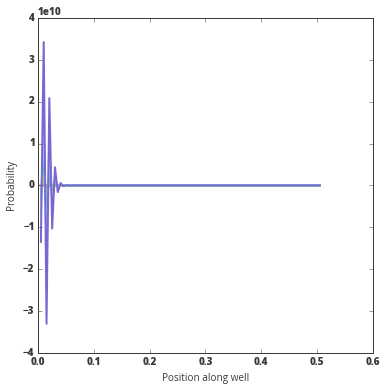

In [38]:
# plot time slices
figure()
solrange = len(sol[0,:])
num_slices = 20
hold(True)
slice_range = floor(solrange/num_slices)
for ii in range(num_slices):
    plot(space, sol[:,ii*slice_range])
plot(space, sol[:,-1])
# ylim([0,10])
rcParams['font.family']='Open Sans'
xlabel("Position along well")
ylabel("Probability")
namestr = 'alpha_' + str(params['ALPHA']) + '__diffu_' + str(params['DCOEFF'])+'__kappa_' +\
str(params['KAPPA'])+'__reacdiam_' +str(params['WELL_DIAM'])+'__potdiam_' + str(params['POT_DIAM'])
# savefig(namestr+'.pdf')


# figure() 
# total_conc = sum(sol, axis = 0)
# plot(times, total_conc[:-1])
# ylabel("Total count")
# xlabel("time")

Right now, this version of the system seems fussier than the version with the power-law time in the normal place. Curiously, the instability appears to propagate from the edge of the reaction zone, rather than the origin.